In [22]:
#imports
import numpy as np
import matplotlib.pyplot as plt

Deciding to create a nonlinear process model that involves ship heading, this is non linear as the position depends on a product of two states, the heading angle and the velocity of the ship.

In [23]:
x = np.array([0, 0, 8, np.pi / 4]) #px, py, v, heading angle(phi)

P = np.diag([100, 100, 4, 0.1]) #once again initialising covariances to zero, because I'm making the easy assumption that all the variables are independent

Q = np.zeros((4,4))

sigma_v = 0.5 # m/s uncertainty
sigma_psi = 0.01 # rad uncertainty
Q[2,2] = sigma_v ** 2
Q[3,3] = sigma_psi **2

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # Measurement matrix (we only measure position)


sigma_pos = 5.0  # meters
R = np.diag([sigma_pos**2, sigma_pos**2])

The Process Model:

\[
\begin{aligned}
p_{x_{k+1}} &= p_{x_{k}} + v_k \cos(\psi_k)\, dt \\
p_{y_{k+1}} &= p_{y_{k}} + v_k \sin(\psi_k)\, dt \\
v_{k+1}   &= v_k \\
\psi_{k+1} &= \psi_k
\end{aligned}
\]

In [24]:
def FJacobian(x, dt):
    """ compute Jacobian of F matrix at x """
    speed = x[2]
    psi = x[3]

    F = np.eye(4)
    F[0, 2] = np.cos(psi) * dt
    F[0, 3] = -speed * np.sin(psi) * dt

    F[1, 2] = np.sin(psi) * dt
    F[1, 3] = speed * np.cos(psi) * dt

    return F

In [25]:
def f(x, dt):
    px, py, v, psi = x
    
    px_new = px + v * np.cos(psi) * dt
    py_new = py + v * np.sin(psi) * dt
    v_new = v
    psi_new = psi
    
    return np.array([px_new, py_new, v_new, psi_new])

In [26]:
#Extended Kalman Filter Functions

#Kalman Filter Functions

def predict(x, P, Q, dt):
    x_pred = f(x, dt) @ x
    
    F = FJacobian(x, dt)

    P_pred = F @ P @ F.T + Q
    
    return x_pred, P_pred

def update(x_pred, P_pred, z, H, R):
    y = z - H @ x_pred  # Measurement residual
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x_upd = x_pred + K @ y
    I = np.eye(P_pred.shape[0])
    P_upd = (I - K @ H) @ P_pred
    return x_upd, P_upd, y, S

In [27]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2*np.pi) - np.pi

In [28]:
def ekf_step(x, P, z, Q, R, dt):
     """
    One EKF step (predict + update)

    x : current state estimate (4,)
    P : current covariance (4x4)
    z : measurement (2,)
    Q : process noise covariance (4x4)
    R : measurement noise covariance (2x2)
    dt : timestep
    """

     # ======================
     # 1️⃣ Prediction
     # ======================

     # Nonlinear state propagation
     x_pred = f(x, dt)

     # Linearisation (Jacobian of process model)
     F = FJacobian(x, dt)

     # Covariance propagation
     P_pred = F @ P @ F.T + Q

     # ======================
     # 2️⃣ Update
     # ======================

     # Innovation (residual)
     y = z - H @ x_pred

     # Innovation covariance
     S = H @ P_pred @ H.T + R

     # Kalman gain
     K = P_pred @ H.T @ np.linalg.inv(S)

     # State update
     x_upd = x_pred + K @ y

     # Covariance update
     I = np.eye(len(x))
     P_upd = (I - K @ H) @ P_pred

     # Wrap heading angle
     x_upd[3] = wrap_to_pi(x_upd[3])

     # Numerical symmetry fix (optional but good practice)
     P_upd = 0.5 * (P_upd + P_upd.T)

     return x_upd, P_upd, y, S

In [29]:
def simulate_truth(N, dt):
    x_true = np.zeros((N, 4))  # px, py, v, psi

    # Initial state
    x_true[0] = np.array([0, 0, 8, np.pi/6])

    turn_rate = 0.01  # rad/sec (gentle turn)

    for k in range(1, N):
        px, py, v, psi = x_true[k-1]

        psi = psi + turn_rate * dt

        px = px + v * np.cos(psi) * dt
        py = py + v * np.sin(psi) * dt

        x_true[k] = np.array([px, py, v, psi])

    return x_true

In [30]:
def simulate_measurements(x_true, sigma_pos):
    N = x_true.shape[0]
    z = np.zeros((N, 2))

    for k in range(N):
        noise = np.random.randn(2) * sigma_pos
        z[k] = x_true[k, 0:2] + noise

    return z

In [31]:
def run_ekf(z, x0, P0, Q, R, dt):
    N = len(z)
    x_estimates = np.zeros((N, 4))
    x = x0.copy()
    P = P0.copy()

    for k in range(N):
        x, P, _, _ = ekf_step(x, P, z[k], Q, R, dt)
        x_estimates[k] = x

    return x_estimates

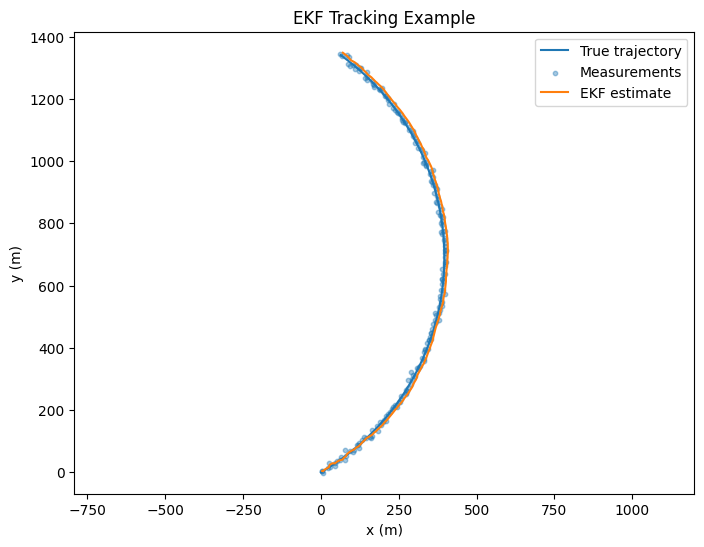

In [36]:


dt = 1.0
N = 200

# Simulate
x_true = simulate_truth(N, dt)
z = simulate_measurements(x_true, sigma_pos=5)

# Initial guess
x0 = np.array([0, 0, 7, np.pi/4])
P0 = np.diag([100, 100, 4, 0.1])

# Noise matrices
sigma_v = 0.2
sigma_psi = 0.005
Q = np.zeros((4,4))
Q[2,2] = sigma_v**2
Q[3,3] = sigma_psi**2

sigma_pos = 5.0
R = np.diag([sigma_pos**2, sigma_pos**2])

# Run filter
x_est = run_ekf(z, x0, P0, Q, R, dt)

# Plot
plt.figure(figsize=(8,6))
plt.plot(x_true[:,0], x_true[:,1], label="True trajectory")
plt.scatter(z[:,0], z[:,1], s=10, alpha=0.4, label="Measurements")
plt.plot(x_est[:,0], x_est[:,1], label="EKF estimate")
plt.legend()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("EKF Tracking Example")
plt.axis("equal")
plt.show()

TODO: Need to do an EKF for the AIS data without converting latitude and longitude to cartesian coordinates, and then compare my results to the linear Kalman Filter